# Model Interpretability using LIME and SHAP
Dennis Tseng <br>
Dongmin Sun <br>
Scott Elmore <br>
DSC 672 - Group 3<br>
Final Project - Abbreviated Training Pipeline Example <br>

The following is a Jupyter notbook example of the full training pipeline found within train_discrete.py. The full code should be found in the rest of the /src/ directory

# Load Packages

In [1]:
# Standard packages
import sys
import csv
import math
import numpy as np
import pandas as pd
from operator import itemgetter
import time
from collections import Counter

# Pipeline, if not using imblearn comment that out and use sklearn's pipeline instead
from sklearn.pipeline import make_pipeline, Pipeline
#from imblearn.pipeline import make_pipeline, Pipeline

# Some sklearn tools for preprocessing, feature selection and etc
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, scale, MinMaxScaler
from sklearn.feature_selection import RFE, RFECV, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn.decomposition import PCA

# Imbalanced Datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

# Classifiers
import xgboost.sklearn as xgb

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer

# Model Exporting
#from sklearn.externals import joblib
import pickle

# Model Interpretability
import shap

from numpy.ma import MaskedArray
import sklearn.utils.fixes
import matplotlib.pyplot as plt
sklearn.utils.fixes.MaskedArray = MaskedArray

# pip install tune-sklearn ray[tune]
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


# Global Parameters

Global parameters are used to toggle specific actions within the training process. For example, if hyper-parameter tuning is unecessary or done, param_tuning can be set to = 0. These parameters control what gets added into the Scikit Learn pipeline, so it can be general use depending on the type of project and data.

In [2]:
imb_class=0                                         #Control switch for type of sampling to deal with imbalanced class (0=None, 1=SMOTE, 2=NearMiss, 3=RandomUnderSampler)
cross_val= 0                                        #Control Switch for CV
base_classifiers = 0                                #Apply base classifier as baseline if CV is turned on
norm_features=1                                     #Normalize features switch
pca = 0
feat_select=0                                       #Control Switch for Feature Selection
fs_type=2                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)
lv_filter=0                                         #Control switch for low variance filter on features
k_cnt= 20                                           #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3
param_tuning = 0                                    #Turn on model parameter tuning
exhaustive_search = 0                               #Turn on if you want exhaustive grid search. Otherwise, it will default to RandomizedSearchCV
neural_network = 0                                  #Turn on if you want to train a neural network. Does not use pipelineing structure!!!
feature_importance = 1                              #Turn on shap if cross_val = 0

#Set global model parameters
rand_st=0                                           #Set Random State variable for randomizing splits on runs

# Load Data

Loading data and some light pre-processing:

In [3]:
data = pd.read_csv("../../data/clean/model_plays.csv", low_memory = False)

# Result of Feature Selection - Other Script
data.drop(['play_type_punt', 'Fog', 'ld_outcome_end_of_half', 'pd_expl_pass', 'play_type_field_goal', 'play_type_qb_kneel', 'GameMonth', 'Wind', 
           'ld_opp_outcome_end_of_half', 'ld_opp_outcome_punt', 'ld_outcome_field_goal', 'pd_average_tfl', 'Rain', 'Snow', 'def_fs', 'def_le',
           'def_re', 'def_rolb', 'def_ss', 'fumble', 'home', 'ld_outcome_fumble_lost', 'ld_outcome_interception', 'ld_outcome_touchdown',
           'off_lg', 'off_rg', 'off_te', 'def_cb', 'def_dt', 'def_mlb', 'ld_drive_length', 'ld_expl_pass', 'ld_plays', 'off_rt', 'pd_pass_yard_att',
           'qb_scramble', 'def_lolb', 'ld_opp_outcome_field_goal', 'ld_opp_outcome_interception', 'ld_opp_outcome_no_ld', 'ld_outcome_no_ld',
           'ld_outcome_punt', 'ld_outcome_turnover_on_downs', 'off_c', 'qb_spike', 'play_type_qb_spike' , 'pd_average_plays', 'pd_average_sacks', 'pd_average_top'
           , 'pd_avg_interceptions'], axis = 1, inplace = True)

# Test for run and pass predictors. Comment out if we don't want this
data = data[((data['target'] == 'run') |  (data['target'] == 'pass'))]

# Change categorical variables to numerical
data['target'] = data['target'].astype('category').cat.codes
# data['target'] = data['target'].map(target_cat_label)

# Create 2019 Bears Dataset to use as our SHAP/model interpretability dataset
bears = data.copy()
bears = bears[((bears['posteam'] == 'CHI') & (bears['GameYear'] == 2019))]

# Remove unecessary features/columns
del data['posteam']
del data['GameYear']
del bears['posteam']
del bears['GameYear']

# Isolate Target Variable
bears_target = bears['target']
del bears['target']
target = data['target']
del data['target']

# Remove labels
data_ids = data[['play_id', 'game_id']]
del data['play_id']
del data['game_id']
del bears['play_id']
del bears['game_id']


This would be where we create a train test split so that we have a validation set during hyperparameter tuning and etc, but since we aren't formally doing it within this jupyter notebook, this is disabled:

In [4]:
'''
# Split prior to any normalization/sampling. Stratify is set understanding that we have imbalanced classes and want to preserve that in the split

# If doing model evaluation use entire dataset
if cross_val == 1:
    data_train = data.copy()
    target_train = target.copy()
else:
    #If hyperparameter tuning, use subset of data for speed purposes
    sample_train, sample_test, sample_target_train, sample_target_test = train_test_split(data, target, test_size=0.50, stratify = target)
    data_train, data_test, target_train, target_test = train_test_split(sample_train, sample_target_train, test_size=0.50, stratify = sample_target_train)
    data_shap, data_shap_test, target_shap, target_shap_test = train_test_split(data_test, target_test, test_size=0.98, stratify = target_test)
'''

'\n# Split prior to any normalization/sampling. Stratify is set understanding that we have imbalanced classes and want to preserve that in the split\n\n# If doing model evaluation use entire dataset\nif cross_val == 1:\n    data_train = data.copy()\n    target_train = target.copy()\nelse:\n    #If hyperparameter tuning, use subset of data for speed purposes\n    sample_train, sample_test, sample_target_train, sample_target_test = train_test_split(data, target, test_size=0.50, stratify = target)\n    data_train, data_test, target_train, target_test = train_test_split(sample_train, sample_target_train, test_size=0.50, stratify = sample_target_train)\n    data_shap, data_shap_test, target_shap, target_shap_test = train_test_split(data_test, target_test, test_size=0.98, stratify = target_test)\n'

#### Calculates Shannon Entropy - a measure of class imbalance <br>
As suggested by Simone Romano, PhD. <br>
https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance

In [5]:
def balance(seq):
    n = len(seq)
    classes = [(clas,float(count)) for clas,count in Counter(seq).items()]
    k = len(classes)

    H = -sum([ (count/n) * np.log((count/n)) for clas,count in classes]) #shannon entropy
    return H/np.log(k)

print('The balance of classes within the dataset is: ', balance(target))
print('If this is far less than 1.0, please consider turning on the imblearn class balancing portions of the pipeline!')

The balance of classes within the dataset is:  0.9725161679310111
If this is far less than 1.0, please consider turning on the imblearn class balancing portions of the pipeline!


# Create SKLearn Pipelines

SKLearn pipelines allow all parts of the pre-processing steps to be included within k-fold cross validation and hyperparmeter tuning. This is important, because if we scale or sample the dataset and then split the dataset, we've unintentionally encoded some information into each of the folds, which we do not want to do. Using a pipeline ensures that each fold is individually scaled and up/down-sampled. For this example, we only create 1 pipeline for our best model - XGBoost:

In [6]:
# A pipeline's steps is just a list. We just create an empty list that will be appended to:
xg_pipe = []
skpipes = [xg_pipe]

In [7]:
# Normalizing using Standard Scaler. This is turned ON for this jupyter notebook
if norm_features == 1:
    for i in range(0, len(skpipes)):
        skpipes[i].append(('scalar'+str(i),StandardScaler()))
     
# Dealing with imbalanced classes. We have this turned off for this jupyter notebook
if imb_class == 0:
    pass
elif imb_class == 1:
    # Oversample with SMOTE
    print('Balanced Classes Turned On')
    for i in range(0, len(skpipes)):
        skpipes[i].append(('smote'+str(i), SMOTE(random_state = rand_st)))
        
elif imb_class == 2:
    # Undersample using NearMiss
    print('Balanced Classes Turned On')
    for i in range(0, len(skpipes)):
        skpipes[i].append(('NearMiss'+str(i), NearMiss(version=3)))
    
elif imb_class == 3:
    # Undersample using NearMiss
    print('Balanced Classes Turned On')
    for i in range(0, len(skpipes)):
        skpipes[i].append(('undersample'+str(i), RandomUnderSampler()))
        
# PCA Dimensionality Reduction. This is turned OFF for this jupyter notebook
if pca == 1:
    print('PCA Turned On', '\n')
    for i in range(0, len(skpipes)):
        skpipes[i].append(('pca'+str(i), PCA(n_components = 0.95)))    
    

In [8]:
# List of Classifiers. This has to match the pipe steps list we created above
classifiers = [
               ('xg_classifier', xgb.XGBClassifier())
               ]

# Add the classifier to the pipe steps list. This always has to be last in a pipeline's steps
for i, c in enumerate(classifiers):
    skpipes[i].append(c) 

Now that we've created the list of pipeline steps, we add it to an actual pipeline:

In [9]:
# Tree Methods
xg_pipe = Pipeline(skpipes[0])

# List of all classifier pipelines. If we want to automate hyperparameter tuning, this is what we iterate over
pipelines = [xg_pipe]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {1: 'XGboost'}
pipe_list = ['XGBoost']


# Hyper-Parameter Tuning

We create a grid that we can pass into the pipeline and GridSearchCV, RandomSearchCV, or BayesSearchCV (depends on global parameter toggle)

In [10]:
best_params = []
best_estimator =[]

xg_grid = [{#'xg_classifier__n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 1500, num = 6)],
            'xg_classifier__n_estimators': [1400],
            #'xg_classifier__learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.150, 0.25, 0.5, 1],
            'xg_classifier__learning_rate': [0.01],
            'xg_classifier__min_split_loss': [2],
            #'xg_classifier__min_child_weight': [0, 1, 3, 5, 7],
            'xg_classifier__min_child_weight': [7],
            #'xg_classifier__gamma': [i/10.0 for i in range(0,5)],
            'xg_classifier__gamma': [0],
            #'xg_classifier__max_depth': [3, 5, 7, 9, 11, 13,15, 17, 19, 21, 25],
            'xg_classifier__max_depth': [7],
            #'xg_classifier__booster': ['gbtree', 'gblinear', 'dart'],
            'xg_classifier__booster': ['gbtree'],
            #'xg_classifier__reg_alpha': [0, 0.001, 0.005, 0.1, 0.05, 1e-5, 0.1, 0.25, 0.5, 1, 1.25],
            'xg_classifier__reg_alpha': [0.05],
            'xg_classifier__reg_lambda': [0, 1],
            #'xg_classifier__sampling_method' : ['gradient_based', 'uniform'],
            'xg_classifier__subsample': [0.9],
            #'xg_classifier__subsample': [0.8],
            'xg_classifier__colsample_bytree' : [ 0.6]
            #'xg_classifier__colsample_bytree' : [0.8]
            #'xg_classifier__early_stopping_rounds' : [50],
            #'xg_classifier__eval_metric' : ['auc'],
            #'xg_classifier__eval_set' : [[data_test, target_test]]
           }]


# We've already tuned our model, so this is the final optimal result
xg_opt_grid = {'xg_classifier__n_estimators': 1400,
               'xg_classifier__learning_rate': 0.01,
               'xg_classifier__min_split_loss': 2,
               'xg_classifier__min_child_weight': 7,
               'xg_classifier__gamma': 0,
               'xg_classifier__max_depth': 7,
               'xg_classifier__booster': 'gbtree',
               'xg_classifier__reg_alpha': 0.05,
               'xg_classifier__reg_lambda': 0,
               'xg_classifier__subsample': 0.9,
               'xg_classifier__colsample_bytree' : 0.6
               }

The for loop goes across all grids and pipelines to tune. Just to make sure, we turn on parameter tuning and exhaustive search, but limit the parameters in the grid above:

In [16]:
# Turn on tuning and grid search
param_tuning = 1
exhaustive_search = 1

params = [xg_grid]

opt_params = [xg_opt_grid]

if param_tuning == 1:
    
    gridhistory = []
    
    #scorers = {'AUC' : 'roc_auc'}
    
    for pipe, grid_param, name in zip(pipelines, params, pipe_list):
        print('Tuning Models...')
        start_ts=time.time()
        if exhaustive_search == 1:
            gridsearch = GridSearchCV(pipe, grid_param, scoring = 'roc_auc', cv=5, verbose=10, n_jobs=-1) 
            #gridsearch = TuneGridSearchCV(pipe, grid_param, scoring = 'roc_auc', cv=5, verbose=10, n_jobs=-1) 
        else:    
            gridsearch = RandomizedSearchCV(pipe, param_distributions = grid_param, n_iter=200, scoring = 'roc_auc', cv=5, verbose=20, n_jobs=-1)
            #gridsearch = TuneSearchCV(pipe, param_distributions = grid_param, n_iter = 2, cv = 2, scoring = 'roc_auc', search_optimization='bayesian', verbose=2, n_jobs = -1)
            #gridsearch = BayesSearchCV(pipe, search_spaces = grid_param, n_iter = 200, scoring = 'roc_auc', n_jobs = -1, verbose = 10)
        gridsearch.fit(data, target)
 
        # Get best results        
        best_params.append((name, gridsearch.best_params_, gridsearch.best_score_))
        print(gridsearch.best_params_)
        print(gridsearch.best_score_)
        
        # Save optimized model
        gridhistory.append(gridsearch.cv_results_)
        
        #filename = name + '.sav'
        #best_model = gridsearch.best_estimator_
        #pickle.dump(best_model, open(filename, 'wb'))
        #best_estimator.append(gridsearch.best_estimator_)

Tuning Models...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 10.9min remaining: 25.5min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 10.9min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 11.0min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.2min finished


{'xg_classifier__booster': 'gbtree', 'xg_classifier__colsample_bytree': 0.6, 'xg_classifier__gamma': 0, 'xg_classifier__learning_rate': 0.01, 'xg_classifier__max_depth': 7, 'xg_classifier__min_child_weight': 7, 'xg_classifier__min_split_loss': 2, 'xg_classifier__n_estimators': 1400, 'xg_classifier__reg_alpha': 0.05, 'xg_classifier__reg_lambda': 1, 'xg_classifier__subsample': 0.9}
0.7607295460481847


# Model Evaluation

Take the parameters and do 10-fold cross validation to evaluate cross-model performance. We do the below as an exercise but only use XGBoost. If base_classifiers is = 1, then 

In [21]:
cross_val = 1

####Cross-Val Classifiers####
if cross_val == 1:
    
    classifier_cross_val = pd.DataFrame(data = None, columns = ['Classifier' , 'Accuracy', 'Balanced Accuracy' , 'Precision', 'Average Precision', 'Recall', 'F1', 'AUC']) 
    
    #Setup Crossval classifier scorers
    scorers = {'Accuracy': 'accuracy', 
               'Balanced_Accuracy': 'balanced_accuracy',
               'Precision': 'precision',
               'Average_Precision': 'average_precision',
               'Recall': 'recall',
               'F1': 'f1',
               'AUC' : 'roc_auc'}

    for pipe, param, name in zip(pipelines, opt_params, pipe_list):
        #SciKit Logistic Regression  - Cross Val
        start_ts=time.time()
        if base_classifiers == 0:
            pipe.set_params(**param)
        clf = pipe
        scores = cross_validate(clf, data, target, scoring=scorers, cv= 10)
        scores_Acc = scores['test_Accuracy']
        scores_Bal = scores['test_Balanced_Accuracy']
        scores_Pre = scores['test_Precision']
        scores_avPre = scores['test_Average_Precision']
        scores_Rec = scores['test_Recall']
        scores_F1 = scores['test_F1']
        scores_AUC = scores['test_AUC']
        classifier_cross_val = classifier_cross_val.append({'Classifier': name, 'Accuracy' : "%0.4f (+/- %0.4f)" % (scores_Acc.mean(), scores_Acc.std() * 2), 
                                                            'Balanced Accuracy' : "%0.4f (+/- %0.4f)" % (scores_Bal.mean(), scores_Bal.std() * 2),
                                                            'Precision' : "%0.4f (+/- %0.4f)" % (scores_Pre.mean(), scores_Pre.std() * 2),
                                                            'Average Precision' : "%0.4f (+/- %0.4f)" % (scores_avPre.mean(), scores_avPre.std() * 2),
                                                            'Recall' : "%0.4f (+/- %0.4f)" % (scores_Rec.mean(), scores_Rec.std() * 2),
                                                            'F1' : "%0.4f (+/- %0.4f)" % (scores_F1.mean(), scores_F1.std() * 2),
                                                            'AUC' : "%0.4f (+/- %0.4f)" % (scores_AUC.mean(), scores_AUC.std() * 2)
                                                            },
                                                           ignore_index = True)
    
    '''
    if base_classifiers == 1:
        classifier_cross_val.to_csv('baseline_classifier_scores.csv')
    else:
        classifier_cross_val.to_csv('tuned_classifier_scores.csv')
    '''

In [22]:
classifier_cross_val

,Classifier,Accuracy,Balanced Accuracy,Precision,Average Precision,Recall,F1,AUC
0,XGBoost,0.6989 (+/- 0.0088),0.6830 (+/- 0.0128),0.6331 (+/- 0.0156),0.6628 (+/- 0.0141),0.6010 (+/- 0.0475),0.6163 (+/- 0.0225),0.7604 (+/- 0.0110)


# Feature Importance and SHAP for Model Interpretability

Now that we have our desired model, we need to create a SHAP explainer. However, one thing to note is that you cannot feed a sklearn pipeline. Instead, we'll have to take our model, manually scale the data, and then load just the model object to SHAP. First, let's look at the 'traditional' model feature importance:

In [11]:
feature_importances = []

# XGBoost
clf = xg_pipe
clf.set_params(**xg_opt_grid)
clf.fit(data, target)


'''
# Save the model
pickle.dump(clf, open('xgb_model_final.sav', 'wb'))
#clf.save_model('../../models/xgbmodel_final.bst')
'''

# Built-in Feature Importances
feature_importances.append(('XGboost', clf.named_steps['xg_classifier'].feature_importances_))
fi = []

for f in feature_importances:
    feat = pd.DataFrame(data.columns)
    values = pd.DataFrame(f[1])
    fi.append((f[0],feat.join(values, lsuffix = 'val')))
#pd.DataFrame(fi[0][1]).to_csv('features.csv')    

print(fi[0][1])


                                0val         0
0                       yardline_100  0.013930
1             game_seconds_remaining  0.041936
2                          game_half  0.036215
3                                qtr  0.054496
4                               down  0.118862
5                            ydstogo  0.047958
6                             ydsnet  0.022058
7                       yards_gained  0.041547
8                            shotgun  0.082796
9                          no_huddle  0.026264
10                       qb_dropback  0.043644
11                         air_yards  0.013141
12                 yards_after_catch  0.015739
13                score_differential  0.038442
14                                ep  0.015909
15                               epa  0.069280
16                              sack  0.017466
17                              Dome  0.009488
18                            off_hb  0.009155
19                            off_lt  0.008838
20           

We generate the confusion matrix for the test dataset:

In [59]:
# Bears Predictions
test_predictions = clf.predict(data)
print(classification_report(target, test_predictions))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78    116368
           1       0.68      0.65      0.66     78460

    accuracy                           0.73    194828
   macro avg       0.72      0.72      0.72    194828
weighted avg       0.73      0.73      0.73    194828



To feed into shap, we cannot use pipelines so we scale and train another XGmodel and feed create a SHAP explainer. We'll use a subset of data - plays from the Chicago bears for the 2019 season. First, let's look at the performance using just this subset:

In [12]:
# Bears Predictions
bears_predictions = clf.predict(bears)
scores_ACC = clf.score(bears, bears_target)
print("XGBoost Train Accuracy:",clf.score(data, target))
print('XGBoost Test Acc:', scores_ACC)
print(classification_report(bears_target, bears_predictions))
bears_predictions = pd.DataFrame(bears_predictions, columns = ['Predicted'])

XGBoost Train Accuracy: 0.734653129940255
XGBoost Test Acc: 0.7262135922330097
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       327
           1       0.64      0.58      0.61       188

    accuracy                           0.73       515
   macro avg       0.70      0.70      0.70       515
weighted avg       0.72      0.73      0.72       515



Now lets use SHAP

In [17]:
# SHAP uses a small sample of observations to help generate values. We use split just to get a ~1000 rows to feed it
data_shap, data_shap_test, target_shap, target_shap_test = train_test_split(data, target, test_size=0.995, stratify = target)

# SHAP Implementation    
xg_model = clf.named_steps['xg_classifier']
xg_model = xg_model.get_booster()

standard_scaler = StandardScaler()
data_shap = standard_scaler.fit_transform(data_shap)

standard_scaler = StandardScaler()
bears = standard_scaler.fit_transform(bears)

Unfortunately, the latest version of XGBoost breaks compatibility with the version of SHAP in pypy. The culprit is that there are 4 additional bytes added to the model. We remove them:

In [20]:
a = xg_model.save_raw()

model_bytearray = a[4:]
def myfun(self=None):
    return model_bytearray
xg_model.save_raw = myfun

and now we can run SHAP by creating an explainer with our model and seeding it with the 'data_shap' set of observations. Then, all we do is give it the bears dataset we want to look at:

In [23]:
shap_explainer = shap.TreeExplainer(xg_model, data_shap)
shap_values = shap_explainer.shap_values(bears)

100%|===================| 513/515 [05:58<00:01]        

We can view the shap values for all observations as follows:

In [25]:
results = pd.DataFrame(shap_values, columns = data.columns)
results.head()

,yardline_100,game_seconds_remaining,game_half,qtr,down,ydstogo,ydsnet,yards_gained,shotgun,no_huddle,...,pd_average_points,pd_passer_rating,pd_run_percentage,pd_rush_yard_att,pd_pass_completion_pct,play_type_pass,play_type_run,ld_opp_outcome_fumble_lost,ld_opp_outcome_touchdown,ld_opp_outcome_turnover_on_downs
0,-0.035247,0.184556,-0.017726,0.014262,0.387732,-0.001270,0.009231,0.077907,-0.071204,0.015087,...,0.018213,-0.013035,-0.110943,-0.044105,0.037282,-0.014449,0.024024,-0.001562,0.000524,-0.001968
1,-0.029705,0.180790,-0.021474,0.017088,-0.804855,-0.002839,-0.060887,-0.142044,-0.017555,0.005855,...,0.018425,-0.006574,-0.118009,-0.016832,0.043833,0.017308,-0.033581,-0.001759,0.000406,-0.002004
2,-0.021382,0.268521,-0.032572,0.061754,0.453603,-0.009257,0.043136,-0.039350,-0.043268,0.009323,...,0.017637,-0.011764,-0.106940,-0.030200,0.052006,0.045492,-0.025354,-0.001250,0.000564,-0.001508
3,-0.028191,0.086450,-0.015239,0.001880,-0.669916,-0.080353,-0.042331,-0.127971,-0.044767,0.005995,...,0.015870,-0.010328,-0.093525,-0.028546,0.034899,-0.016409,0.023302,-0.001537,0.000267,-0.002298
4,-0.003804,0.056466,-0.019769,-0.002544,0.326809,-0.012399,0.016669,-0.011697,-0.059783,0.013292,...,0.014220,0.025967,-0.017263,0.009420,0.042965,-0.020134,0.035915,-0.001194,0.000971,-0.001590


We're going to use the above for our Tableau dashboard, but let's look at some of SHAP's features. We first isolate one observation from the 'bears' dataset:

In [49]:
# Pick the 1st observation
bears = pd.DataFrame(bears, columns = data.columns)
print("Observation feature values:\n",bears.iloc[0],"\n")
print("True label:\n",bears_target.iloc[0])

Observation feature values:
 yardline_100                       -0.161787
game_seconds_remaining              1.587956
game_half                          -0.926934
qtr                                -1.322990
down                               -0.878784
ydstogo                             0.269371
ydsnet                             -1.065983
yards_gained                       -0.033321
shotgun                             0.602025
no_huddle                          -0.412861
qb_dropback                        -1.135292
air_yards                          -0.494426
yards_after_catch                  -0.411604
score_differential                  0.113490
ep                                  0.581171
epa                                -0.053579
sack                               -0.173205
Dome                               -0.216213
off_hb                              0.000000
off_lt                              0.000000
off_qb                              0.000000
off_wr                    

We note that these are the scaled values, which is not idea when we want to show the actual values along with the shap values in the Tableau Dashboard. In the actual script, we've accounted for this.

### Local Interpretability

In [46]:
shap.initjs()

Now we can visualize explanations using force_plot. Let's look at the observation from above:

In [54]:
shap.force_plot(shap_explainer.expected_value, shap_values[0,:], bears.iloc[0,:])

### Global Interpretability

SHAP can also plot all of the shap values for every observation in a single force plot:

In [55]:
shap.force_plot(shap_explainer.expected_value, shap_values, features=bears, link="logit")

If we want to look at how each feature contributes to predicting each class, we can call the following:

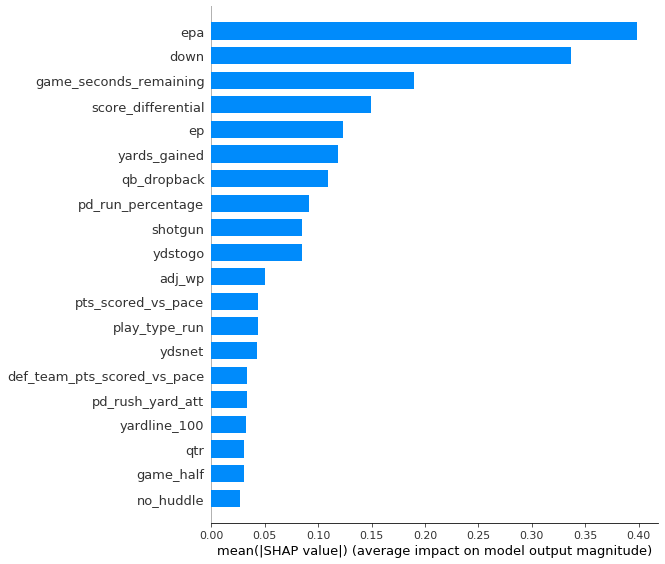

In [56]:
shap.summary_plot(shap_values, bears, plot_type="bar")

This tells us that epa (our proxy variable that determines whether or not a coach thought a play was effective or not), along with down and time remaining, have the highest effect on model results on a global scale. Overall, the results above are consisent with conventional thinking.

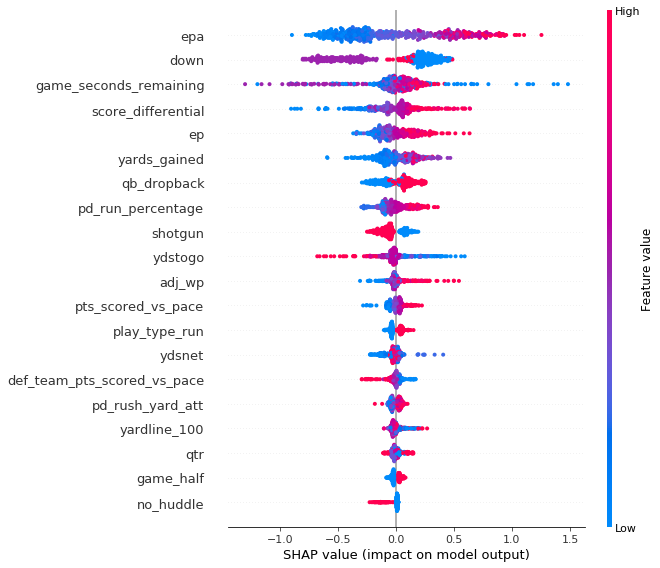

In [57]:
# summarize the effects of all the features
shap.summary_plot(shap_values, bears)

# Contributions:

## Data Collection:
- Dennis Tseng <br>
- Dongmin Sun <br>
- Scott Elmore <br>

## Data Pre-procesing:
- Dennis Tseng

## Feature Engineering:
- Dennis Tseng <br> 
- Dongmin Sun <br>
- Scott Elmore <br>

## Model Training
- Dennis Tseng <br>
- Dongmin Sun <br>

## Feature Importance
- Dennis Tseng <br>
- Dongmin Sun <br>

## Interpretability Visualizations / Dashboards
- Scott Elmore <br>
- Dennis Tseng <br>

## Report and Presentation
- Dennis Tseng <br> 
- Scott Elmore <br>
- Dongmin Sun <br>